### Importing Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import f1_score, precision_recall_fscore_support, recall_score, accuracy_score

### Loading Data

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
data = pd.concat([X, y], axis = 1)

In [4]:
adult.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [5]:
data.shape

(48842, 15)

### EDA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
48842  - 48568     

274

#### Exploring income encoding

In [8]:
# Class imbalance, preprocessing for income column needed
# Consider using f1 score instead of accuracy 
y.assign(count = y["income"]).groupby("income").count()

,count
income,
<=50K,24720
<=50K.,12435
>50K,7841
>50K.,3846


#### Exploring missing and unknown values

In [9]:
# All people with missing workclass also has missing occupation
data[data["workclass"].isna()]["occupation"].unique()

array([nan], dtype=object)

In [10]:
# People with missing occupation either had unknown occupation or never-worked
data[data["occupation"].isna()]["workclass"].unique()

array([nan, 'Never-worked'], dtype=object)

In [11]:
# What is the ? value
data["workclass"].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked',
       nan], dtype=object)

In [12]:
# People with unknown workclass, occupation, and native-country is marked with ?
data[data["workclass"] == "?"]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32531,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32539,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32541,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [13]:
# Which columns have ? values
for col in data.columns:
    if "?" in np.array(data[col]):
        print(col)

workclass
occupation
native-country


C:\Users\kjhoa\AppData\Local\Temp\ipykernel_31736\3838757215.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "?" in np.array(data[col]):


#### Exploring how many rows impacted if drop missing / ? values

In [14]:
data[(data["workclass"] == "?") | (data["workclass"].isna())]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States,<=50K.
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada,<=50K.
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States,<=50K.


In [15]:
data[(data["occupation"] == "?") | (data["occupation"].isna())]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,61,NaN,265201,Some-college,10,Married-civ-spouse,NaN,Husband,White,Male,0,0,14,United-States,<=50K.
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada,<=50K.
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States,<=50K.


In [16]:
data[(data["native-country"] == "?") | (data["native-country"].isna())]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,?,<=50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
93,30,Private,117747,HS-grad,9,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,?,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48245,46,Private,31411,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,NaN,<=50K.
48272,24,Private,127159,Some-college,10,Never-married,Other-service,Other-relative,White,Female,0,0,24,NaN,<=50K.
48604,24,State-gov,161783,Bachelors,13,Never-married,Transport-moving,Not-in-family,Black,Male,0,0,40,NaN,<=50K.
48651,34,Private,143776,Masters,14,Never-married,Prof-specialty,Not-in-family,Black,Male,0,0,45,NaN,>50K.


In [17]:
data[data["workclass"] == "?"]["occupation"].unique()

array(['?'], dtype=object)

In [18]:
data[data["workclass"] == "?"]["native-country"].unique()

array(['South', '?', 'United-States', 'Italy', 'Canada', 'China',
       'Jamaica', 'Haiti', 'Honduras', 'Germany', 'Philippines', 'Mexico',
       'El-Salvador', 'Nicaragua', 'Iran', 'Poland', 'England', 'Taiwan',
       'Portugal', 'Trinadad&Tobago', 'Guatemala', 'Japan', 'Vietnam',
       'Columbia', 'Hong', 'Cuba', 'Laos', 'Ecuador', 'France',
       'Puerto-Rico', 'Dominican-Republic', 'Peru', 'Cambodia',
       'Thailand', 'Scotland'], dtype=object)

In [19]:
data[data["occupation"] == "?"]["workclass"].unique()

array(['?', 'Never-worked'], dtype=object)

In [20]:
data[data["occupation"] == "?"]["native-country"].unique()

array(['South', '?', 'United-States', 'Italy', 'Canada', 'China',
       'Jamaica', 'Haiti', 'Honduras', 'Germany', 'Philippines', 'Mexico',
       'El-Salvador', 'Nicaragua', 'Iran', 'Poland', 'England', 'Taiwan',
       'Portugal', 'Trinadad&Tobago', 'Guatemala', 'Japan', 'Vietnam',
       'Columbia', 'Hong', 'Cuba', 'Laos', 'Ecuador', 'France',
       'Puerto-Rico', 'Dominican-Republic', 'Peru', 'Cambodia',
       'Thailand', 'Scotland'], dtype=object)

In [21]:
data[data["native-country"] == "?"]["workclass"].unique()

array(['Private', '?', 'State-gov', 'Self-emp-not-inc', 'Self-emp-inc',
       'Local-gov', 'Federal-gov'], dtype=object)

In [22]:
data[data["native-country"] == "?"]["occupation"].unique()

array(['Craft-repair', 'Sales', 'Other-service', '?', 'Adm-clerical',
       'Exec-managerial', 'Prof-specialty', 'Machine-op-inspct',
       'Transport-moving', 'Handlers-cleaners', 'Priv-house-serv',
       'Farming-fishing', 'Tech-support', 'Protective-serv'], dtype=object)

In [23]:
# Dropping doesn't impact much
no_missing = data[(data["workclass"] != "?")]
no_missing = no_missing[(no_missing["occupation"]) != "?"]
no_missing = no_missing[no_missing["native-country"] != "?"]
no_missing = no_missing.dropna()

no_missing

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


#### Exploring possibly correlated features

In [24]:
# education-num can be used to encode education
data.groupby(["education", "education-num"])[["age"]].count()

,,age
education,education-num,
10th,6,1389
11th,7,1812
12th,8,657
1st-4th,2,247
5th-6th,3,509
7th-8th,4,955
9th,5,756
Assoc-acdm,12,1601
Assoc-voc,11,2061


#### Exploring how many of each categorical variable there are and distribution

In [25]:
# Number of classes in each categorical cariable
categorical = data.drop(columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", 
                                   "hours-per-week", "income"])
categorical_count = {}
for col in categorical.columns:
    categorical_count[col] = len(categorical[col].unique())
    
categorical_count

{'workclass': 10,
 'education': 16,
 'marital-status': 7,
 'occupation': 16,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 43}

In [26]:
# Function to get count of classes in each feature
def get_distr(col):
    return no_missing.groupby(col)[["age"]].count().sort_values("age")

In [27]:
get_distr("workclass")

,age
workclass,
Without-pay,21
Federal-gov,1406
Self-emp-inc,1646
State-gov,1946
Local-gov,3100
Self-emp-not-inc,3796
Private,33307


In [28]:
get_distr("education")

,age
education,
Preschool,72
1st-4th,222
5th-6th,449
Doctorate,544
12th,577
9th,676
Prof-school,785
7th-8th,823
10th,1223


In [29]:
get_distr("marital-status")

,age
marital-status,
Married-AF-spouse,32
Married-spouse-absent,552
Widowed,1277
Separated,1411
Divorced,6297
Never-married,14598
Married-civ-spouse,21055


In [30]:
get_distr("occupation")

,age
occupation,
Armed-Forces,14
Priv-house-serv,232
Protective-serv,976
Tech-support,1420
Farming-fishing,1480
Handlers-cleaners,2046
Transport-moving,2316
Machine-op-inspct,2970
Other-service,4808


In [31]:
get_distr("relationship")

,age
relationship,
Other-relative,1349
Wife,2091
Unmarried,4788
Own-child,6626
Not-in-family,11702
Husband,18666


In [32]:
get_distr("race")

,age
race,
Other,353
Amer-Indian-Eskimo,435
Asian-Pac-Islander,1303
Black,4228
White,38903


In [33]:
get_distr("sex")

,age
sex,
Female,14695
Male,30527


In [34]:
get_distr("native-country")

,age
native-country,
Holand-Netherlands,1
Hungary,18
Honduras,19
Scotland,20
Laos,21
Outlying-US(Guam-USVI-etc),22
Yugoslavia,23
Trinadad&Tobago,26
Cambodia,26


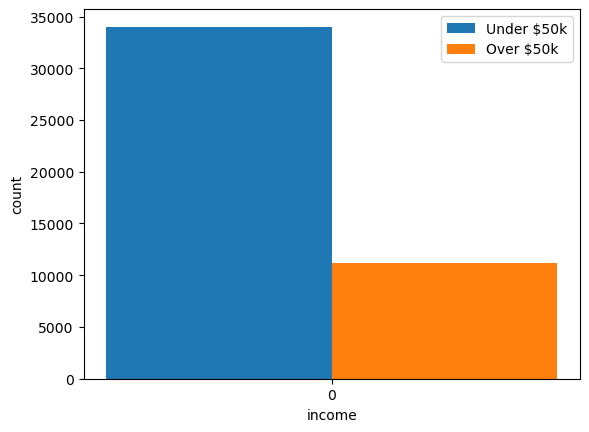

In [48]:
def plotting(data, col, N):
    idx = np.arange(N)
    width = 0.3
    over = data[data["income"] == 1]
    under = data[data["income"] == 0]
    over_grouped = over.groupby(col)["age"].count().reset_index().sort_values(col)
    under_grouped = under.groupby(col)["age"].count().reset_index().sort_values(col)
    values = under_grouped[col]
    plt.bar(idx, under_grouped["age"], width, label = "Under $50k")
    plt.bar(idx + width, over_grouped["age"], width, label = "Over $50k")
    plt.xticks(idx + width / 2, values)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()
    plt.show()
    
plotting(preproc_data, "income", 1)

#### Exploring capital gain and capital loss

In [36]:
no_missing["capital-gain"].describe()

count    45222.000000
mean      1101.430344
std       7506.430084
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

In [37]:
no_missing["capital-loss"].describe()

count    45222.000000
mean        88.595418
std        404.956092
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital-loss, dtype: float64

### Preprocessing

1. Replace nan with ? to represent unknown category or drop all missing and ? values
2. Preprocess income to be a binary value
3. Drop education column since education-num encodes that

In [38]:
# Encodes if you made over 50k as 1 and under 50k as 0
preproc_data = no_missing.assign(income = data["income"].str.split(".").str[0].apply(lambda x: 1 if x[0] == ">" else 0))
# Drop education column
preproc_data = preproc_data.drop(columns = ["education", "fnlwgt"])

In [39]:
preproc_data.groupby("income").count()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
income,,,,,,,,,,,,
0,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014,34014
1,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208,11208


### Class Imbalance

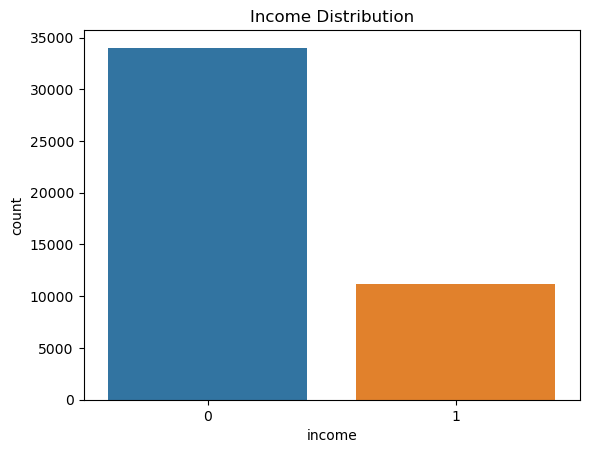

In [50]:
sns.countplot(x = preproc_data["income"])
plt.title("Income Distribution")
plt.savefig('income_distr.png')

### Pair Plot

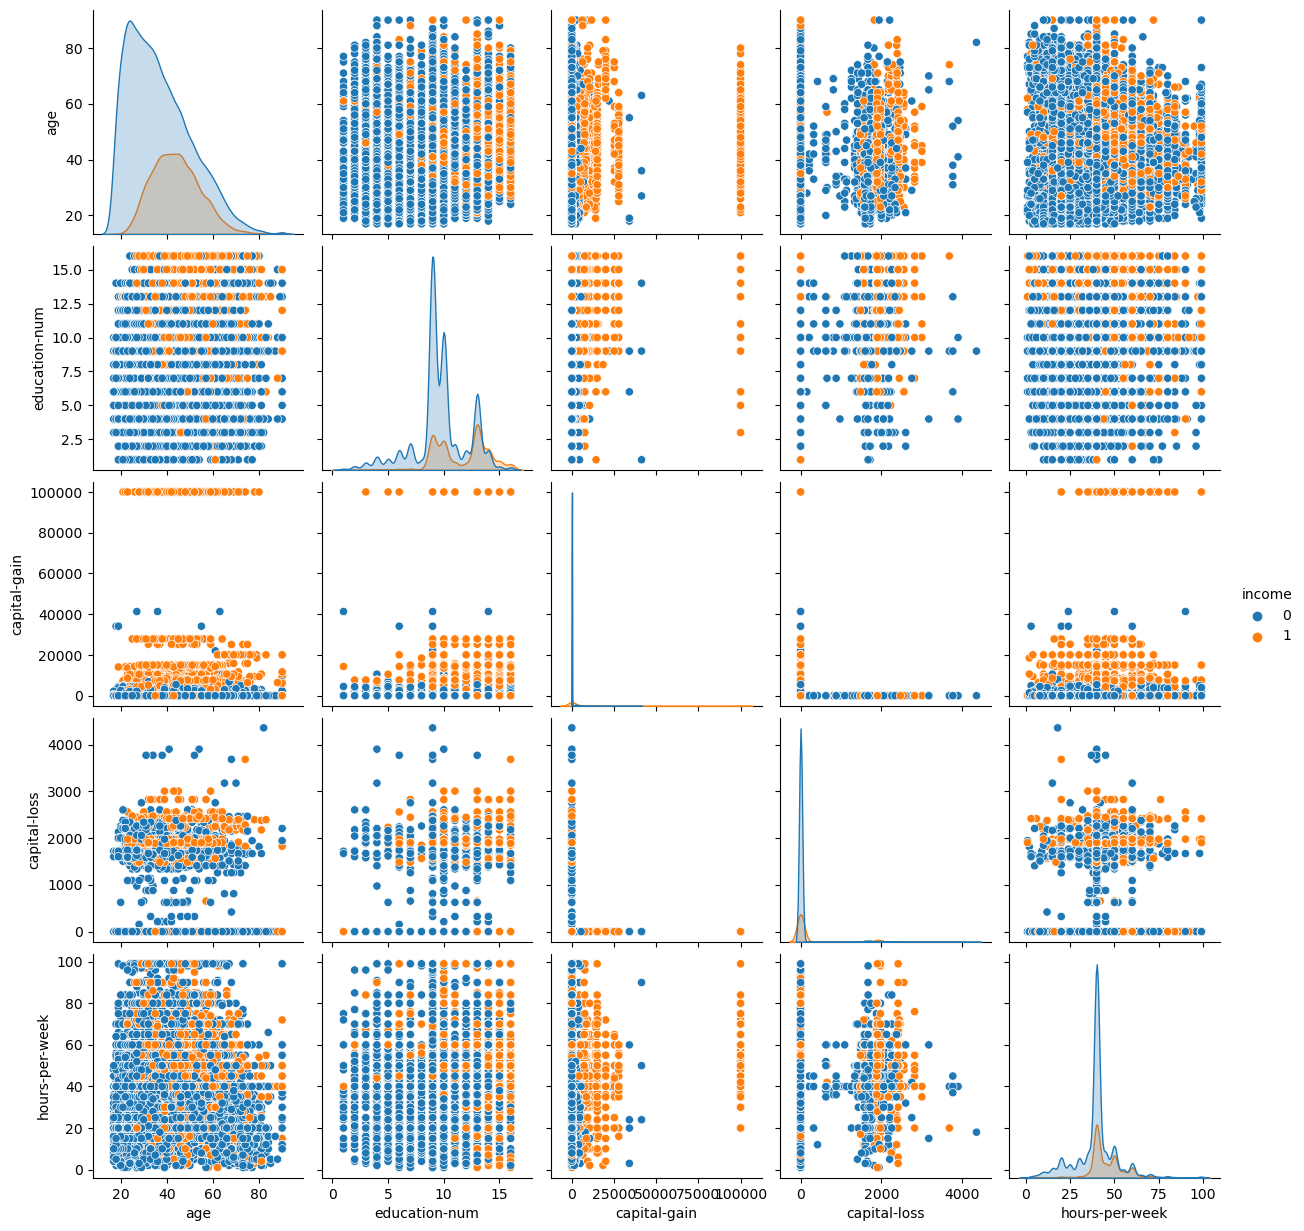

In [51]:
numeric = preproc_data[["age", "education-num", "capital-gain", "capital-loss", "hours-per-week", "income"]]

sns.pairplot(numeric, hue = "income")
plt.savefig('features.png')

### Train Test Validation Split

In [39]:
X = preproc_data.drop(columns = "income")
y = preproc_data["income"]

In [40]:
train = 0.6
val = 0.2
test = 0.2
new_val = val / (1 - test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = new_val, random_state = 42)

### Baselin Model - KNN

In [46]:
preproc = ColumnTransformer(
    transformers = [
        ("categorical", OneHotEncoder(handle_unknown='ignore', sparse_output = False), ["race", "sex", "workclass"]),
        ("numerical", "passthrough", ["age", "hours-per-week", "education-num"])
    ],
    remainder = "drop"
)

In [47]:
pl = Pipeline([
    ("preproc", preproc),
    ("model", KNeighborsClassifier())
])

pl.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['race', 'sex', 'workclass']),
                                                 ('numerical', 'passthrough',
                                                  ['age', 'hours-per-week',
                                                   'education-num'])])),
                ('model', KNeighborsClassifier())])

In [48]:
recall_score(y_val, pl.predict(X_val))

0.8893093661305582

In [49]:
f1_score(y_val, pl.predict(X_val))

0.8597935450150268

In [50]:
accuracy_score(pl.predict(X_test), y_test)

0.7862626676220699